## Demonstrate pure-steam runaway OLR behaviour

AGNI is designed to be used as an executable program, but this notebook applies it as a package for the purposes of demonstrating the famous OLR-$T_s$ curve.   
In this sense, Julia will be familiar to Python users.   

### Import things
This assumes that SOCRATES is installed at `AGNI/socrates/`. Modify this as required.

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [2]:
# Import system packages
using Printf
using DelimitedFiles
using Plots

# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.energy as energy
import AGNI.setpt as setpt

# Disable logging from AGNI module
AGNI.setup_logging("",true)

### Define atmosphere parameters

In [3]:
# Configuration options
instellation    = 1000.0  # Solar flux [W m-2]
gravity         = 9.81
radius          = 6.0e6
nlev_centre     = 100
p_surf          = 300.0     # bar
p_top           = 1e-8      # bar 
mole_fractions  = Dict([("H2O", 1.0)])
run_len         = 20

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Oak/Oak.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/Users/nichollsh/Projects/AGNI/out/"

In [4]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

### Initialise the atmosphere

In [5]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, 1.0, 0.0, 48.19,
                        1700.0,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mf_dict=mole_fractions,
                        flag_gcontinuum=true,
                        thermo_functions=false
                        )
atmosphere.allocate!(atmos, star_file)

### Run the model across an interval of $T_s$ values   
The fluxes are calculated at each pressure and wavelength point, but we only need the OLR.

In [6]:
# Setup arrays for OLR curve
tsurf_arr = range(200,stop=2400,length=run_len)
olr_arr = zeros(Float64, run_len);

In [7]:
# Loop over Tsurf, calculating OLR for each
p_boa = atmos.p_boa
plot_frames = false

for i in 1:run_len
    
    # Set PT profile 
    atmos.p_boa = p_boa
    atmosphere.generate_pgrid!(atmos)
    atmos.tmp_surf =  tsurf_arr[i]
    atmos.tmpl[end] = tsurf_arr[i]

    setpt.prevent_surfsupersat!(atmos)
    setpt.dry_adiabat!(atmos)
    setpt.condensing!(atmos, "H2O")

    # Calculate LW fluxes 
    energy.radtrans!(atmos, true)

    olr = atmos.flux_u_lw[1]
    @printf("%2d: Tsurf = %4.1f K  ,  OLR = %5.1f W m-2 \n",i,atmos.tmpl[end],olr)
    olr_arr[i] = olr 

    if plot_frames 
        tsurf = round(Int,atmos.tmpl[end])
        plotting.plot_pt(atmos, joinpath(output_dir,"pt_$tsurf.png"))
        atmosphere.write_pt(atmos, joinpath(output_dir, "pt_$tsurf.csv") )
    end

end

 1: Tsurf = 200.0 K  ,  OLR =  90.7 W m-2 
 2: Tsurf = 315.8 K  ,  OLR = 283.7 W m-2 
 3: Tsurf = 431.6 K  ,  OLR = 282.8 W m-2 
 4: Tsurf = 547.4 K  ,  OLR = 282.0 W m-2 
 5: Tsurf = 663.2 K  ,  OLR = 281.7 W m-2 
 6: Tsurf = 778.9 K  ,  OLR = 281.6 W m-2 
 7: Tsurf = 894.7 K  ,  OLR = 281.5 W m-2 
 8: Tsurf = 1010.5 K  ,  OLR = 281.4 W m-2 
 9: Tsurf = 1126.3 K  ,  OLR = 281.2 W m-2 
10: Tsurf = 1242.1 K  ,  OLR = 281.1 W m-2 
11: Tsurf = 1357.9 K  ,  OLR = 280.9 W m-2 
12: Tsurf = 1473.7 K  ,  OLR = 280.8 W m-2 
13: Tsurf = 1589.5 K  ,  OLR = 280.9 W m-2 
14: Tsurf = 1705.3 K  ,  OLR = 282.1 W m-2 
15: Tsurf = 1821.1 K  ,  OLR = 286.6 W m-2 
16: Tsurf = 1936.8 K  ,  OLR = 300.3 W m-2 
17: Tsurf = 2052.6 K  ,  OLR = 336.4 W m-2 
18: Tsurf = 2168.4 K  ,  OLR = 421.9 W m-2 
19: Tsurf = 2284.2 K  ,  OLR = 607.3 W m-2 
20: Tsurf = 2400.0 K  ,  OLR = 980.4 W m-2 


### Save these data to a CSV

In [8]:
# Write data 
@printf("Writing data\n")
open(joinpath(output_dir,"OLR_vs_Tsurf.csv"),"w") do hdl 
    writedlm(hdl, [tsurf_arr olr_arr], ", ")
end 

Writing data


### Make plot using the Plots library

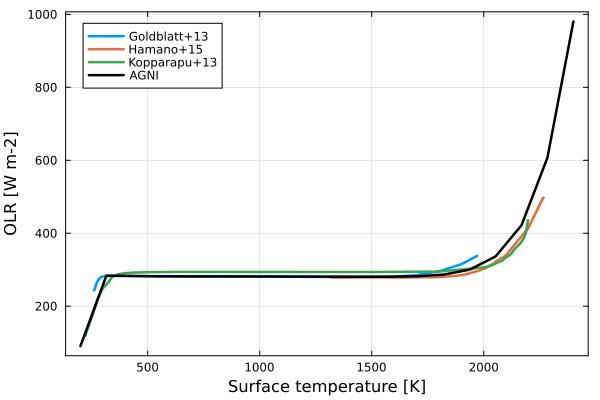

Making plot


In [9]:
# Make plot
@printf("Making plot\n")
plt = plot(framestyle=:box)

lw=2.5

litdata = readdlm(joinpath(ROOT_DIR,"res/literature_data/runaway/Goldblatt13_data.txt"), ',', Float64; header=false, skipstart=2)
plot!(plt, litdata[:,1] , litdata[:,2], label="Goldblatt+13", lw=lw)

litdata = readdlm(joinpath(ROOT_DIR,"res/literature_data/runaway/Hamano15_data.txt"), ',', Float64; header=false, skipstart=2)
plot!(plt, litdata[:,1] , litdata[:,2], label="Hamano+15", lw=lw)

litdata = readdlm(joinpath(ROOT_DIR,"res/literature_data/runaway/Kopparapu13_data.txt"), ',', Float64; header=false, skipstart=2)
plot!(plt, litdata[:,1] , litdata[:,2], label="Kopparapu+13", lw=lw)

plot!(tsurf_arr,olr_arr,label="AGNI", lw=lw, linecolor=:black)

xlabel!(plt, "Surface temperature [K]")
ylabel!(plt, "OLR [W m-2]")

# Show in notebook
display(plt)

# Save to output
savefig(plt, joinpath(output_dir,"runaway_olr.pdf"));

We can see that AGNI (and SOCRATES, in particular) is reproducing the literature results.

In [10]:
# Deallocate atmosphere if required
# atmosphere.deallocate!(atmos)
@printf("Done!")

Done!